# **Import packages**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.utils import resample
import seaborn as sns
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    Conv2D,
    Flatten,
    BatchNormalization,
    GlobalMaxPooling1D,
    SpatialDropout1D,
    MaxPooling1D,
    TimeDistributed,
    MaxPooling2D,
    GlobalMaxPooling2D,
    Dense,
    Dropout,
    Embedding,
    LSTM,
    Bidirectional
)
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import metrics 
import itertools
from itertools import cycle
from sklearn.metrics import classification_report, auc

# **Load and prepare data**

In [2]:
df = pd.read_csv('/kaggle/input/ifnd-dataset/IFND.csv',encoding = "ISO-8859-1")

In [3]:
df.head(2)

,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE


In [4]:
df = df[['Statement', 'Label']]

In [5]:
df.isnull().sum()

Statement    0
Label        0
dtype: int64

In [6]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [7]:
# shuffling rows
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Statement,Label
0,Portugal backs IndiaÕs permanent membership bi...,1
1,Nursery admissions to begin from 18 February i...,1
2,Troll Page 'Presstitutes' Posts Photoshopped T...,0
3,Uttarakhand flash flood ï¿½ 53 bodies recovere...,1
4,"In Uttar Pradesh, the third Modi wave is as st...",1


In [8]:
import re

def clean_statements(statement):  
    
    # Retaining only alphabets.
    statement = re.sub("[^a-zA-Z]"," ",statement)
    
    # Converting to lower case and splitting
    word_tokens= statement.lower().split()
    
    # Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_statement=" ".join(word_tokens)
    return cleaned_statement

In [9]:
print(df.shape)

(56714, 2)


In [10]:
statments=[]
for statement in df['Statement']:
    cleaned_sent=clean_statements(statement)
    statments.append(cleaned_sent.split()) 
    
print(len(statments))  

56714


In [11]:
for w in statments[:3]:
    print(w,"\n")

['portugal', 'back', 'india', 'permanent', 'membership', 'bid', 'un', 'security', 'council'] 

['nursery', 'admission', 'begin', 'february', 'delhi'] 

['troll', 'page', 'presstitutes', 'post', 'photoshopped', 'tweet', 'mirror', 'tv'] 



# **Word2Vec**

In [12]:
import gensim
w2v_model=gensim.models.Word2Vec(sentences=statments,vector_size=200,window=5,min_count=1)

In [13]:
# total numberof extracted words

vocab=w2v_model.wv.index_to_key
print("Vocabulary : ",len(vocab))

Vocabulary :  22369


In [14]:
df.head(3)

,Statement,Label
0,Portugal backs IndiaÕs permanent membership bi...,1
1,Nursery admissions to begin from 18 February i...,1
2,Troll Page 'Presstitutes' Posts Photoshopped T...,0


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(statments)
Statement_seq = tokenizer.texts_to_sequences(statments)

In [16]:
max_rev_len=20 # max lenght of a title
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim=200 # embedding dimension as choosen in word2vec constructor

In [17]:
statement= pad_sequences(Statement_seq, maxlen=max_rev_len, padding='post')
statement.shape

(56714, 20)

In [18]:
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict))

The no of key-value pairs :  22369


In [19]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenizer.word_index.items():
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector

<AxesSubplot:xlabel='Label', ylabel='count'>

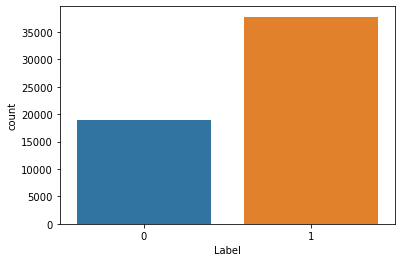

In [20]:
import seaborn
seaborn.countplot(x=df['Label'])

In [21]:
label = (df['Label']) 
X_train,X_test,y_train,y_test=train_test_split(statement,label,test_size=0.20,random_state=42)

In [22]:
X_test, X_val, y_test, y_val = train_test_split (X_test,y_test,test_size=0.5)

In [23]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(45371, 20) (45371,)
(5672, 20) (5672,)
(5671, 20) (5671,)


# **Build Model**

In [24]:
pip install focal_loss 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 37.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 45.6 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not install

In [96]:
class CNN(tf.keras.Model):
    def __init__(self,num_tokens,embedding_dim, embedding_vectors,dropout1=0.2, dropout2=0.5):
        super(CNN, self).__init__()
        
        self.embedding_layer = Embedding(
            num_tokens,
            embedding_dim,
            embeddings_initializer=keras.initializers.Constant(embedding_vectors),
            trainable=False,
        )
        
        self.drop1 = SpatialDropout1D(0.25)
        self.conv1 = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')
        self.pool1 = MaxPooling1D(pool_size=2,strides=1)
        self.patchnorm1 = BatchNormalization()
        
        self.drop2 = SpatialDropout1D(0.5)
        self.conv2 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')
        self.pool2 = MaxPooling1D(pool_size=2,strides=1)
        self.patchnorm2 = BatchNormalization()
        
        self.drop3 = SpatialDropout1D(0.5)
        self.conv3 = Conv1D(filters=64, kernel_size=4, padding='same',
                                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))
        self.act1 = tf.keras.layers.LeakyReLU(alpha=0.3)
        self.pool3 = MaxPooling1D(pool_size=2,strides=1)
        self.patchnorm3 = BatchNormalization()
        self.drop4 = SpatialDropout1D(0.5)
        self.GMPool = GlobalMaxPooling1D()

        self.flatten = Flatten()
        self.out = Dense(2, activation="softmax")
        
        
    def call(self, inputs):
        
        x = self.embedding_layer(inputs)
        x = self.drop1(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.patchnorm1(x)
        x = self.drop2(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.patchnorm2(x)
        '''x = self.drop3(x)
        x = self.conv3(x)
        x = self.patchnorm3(x)
        x = self.drop4(x)'''
        x = self.GMPool(x)
        x = self.flatten(x)
        x = self.out(x)

        return x

In [97]:
def CNN_():
    input_layer = Input(shape=(X_train.shape[1],))
    x = CNN(num_tokens=vocab_size,embedding_dim=200, embedding_vectors=embed_matrix)(input_layer)
    return Model(inputs=input_layer, outputs=x)

model = CNN_()

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
cnn_8 (CNN)                  (None, 2)                 4644050   
Total params: 4,644,050
Trainable params: 169,666
Non-trainable params: 4,474,384
_________________________________________________________________


In [98]:
from focal_loss import SparseCategoricalFocalLoss
loss_func = SparseCategoricalFocalLoss(gamma=2)

In [99]:
model.compile(loss=loss_func,optimizer='adam',metrics=["accuracy"])
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True)

In [100]:
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val),epochs=50, callbacks=earlyStopping)

Epoch 1/50
709/709 [==============================] - 6s 6ms/step - loss: 0.1046 - accuracy: 0.8897 - val_loss: 0.0613 - val_accuracy: 0.9242
Epoch 2/50
709/709 [==============================] - 4s 5ms/step - loss: 0.0654 - accuracy: 0.9185 - val_loss: 0.0585 - val_accuracy: 0.9230
Epoch 3/50
709/709 [==============================] - 4s 5ms/step - loss: 0.0616 - accuracy: 0.9210 - val_loss: 0.0566 - val_accuracy: 0.9251
Epoch 4/50
709/709 [==============================] - 4s 6ms/step - loss: 0.0606 - accuracy: 0.9223 - val_loss: 0.0579 - val_accuracy: 0.9270
Epoch 5/50
709/709 [==============================] - 4s 5ms/step - loss: 0.0591 - accuracy: 0.9248 - val_loss: 0.0559 - val_accuracy: 0.9277
Epoch 6/50
709/709 [==============================] - 4s 5ms/step - loss: 0.0582 - accuracy: 0.9254 - val_loss: 0.0568 - val_accuracy: 0.9279
Epoch 7/50
709/709 [==============================] - 4s 6ms/step - loss: 0.0574 - accuracy: 0.9266 - val_loss: 0.0576 - val_accuracy: 0.9260
Epoch 

# **Evaluation && Graphs**

In [101]:
class EvaluateModel():
    
    def __init__(self, classes=2, **kwargs):
        super().__init__(**kwargs)
        self.classes = classes


    def call(self):
        classes = self.classes
    

    def evaluate_model(self, model, X_test, y_test):
        
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        Accuracy = metrics.accuracy_score(y_test, y_pred)
        Sensitivity = metrics.recall_score(y_test, y_pred, average="macro")
        Precision = metrics.precision_score(y_test, y_pred, average="macro")
        F1_score = metrics.f1_score(y_test, y_pred, average="macro")
        Recall = metrics.recall_score(y_test, y_pred, average="macro")
        
        cm = metrics.confusion_matrix(y_test ,y_pred)

        tpr = float(cm[0][0])/np.sum(cm[0])
        fpr = float(cm[1][1])/np.sum(cm[1])

        auc_ = self.AUC(y_test, y_pred)
        
        print("Accuracy   =  ", Accuracy, "\n")
        print("Sensitvity =  ", Sensitivity, "\n")
        print("Precision  =  ", Precision, "\n")
        print("F1 Score   =  ", F1_score, "\n")
        print("Recall     =  ", Recall, "\n")
        print("fpr        =  ", fpr, "\n")
        print("tpr        =  ", tpr, "\n")
        print("AUC        =  ", auc_, "\n") 
        
        return Accuracy, Sensitivity, Precision, F1_score, Recall, fpr, tpr, auc_

    def plot_roc_curve(self, model, X_test, y_test, classes=2):
        y_pred = model.predict(X_test)
        y_test = to_categorical(y_test, classes)
        y_pred = to_categorical(np.argmax(y_pred, axis=1), classes)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(classes):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(
            y_test.ravel(), y_pred.ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        lw = 2
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))

        mean_tpr = np.zeros_like(all_fpr)
        for i in range(classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(10, 10))
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
            color="navy",
            linestyle=":",
            linewidth=4,
        )

        colors = cycle(["aqua", "darkorange", "cornflowerblue"])
        for i, color in zip(range(classes), colors):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            )

        plt.plot([-0.05, 1], [0.0, 1], "k--", lw=lw)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Some extension of Receiver operating characteristic to multiclass")
        plt.legend(loc="lower right")
        plt.show()
        
    
    def AUC(self, actual_class, pred_class, average = "micro"):
    
        unique_class = set(actual_class)
        roc_auc_dict = {}
        for per_class in unique_class:

            other_class = [x for x in unique_class if x != per_class]

            
            new_actual_class = [0 if x in other_class else 1 for x in actual_class]
            new_pred_class = [0 if x in other_class else 1 for x in pred_class]

            
            roc_auc = metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
            roc_auc_dict[per_class] = roc_auc

        return roc_auc_dict

    def Confusion_Matrix(self, model, X_test, y_test, color='Blues'):
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)

        fig, ax = plt.subplots(figsize=(10, 10))
        disp.plot(ax=ax, cmap=color)
        plt.show()

    
    def Classification_Report(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)

        return classification_report(y_test, y_pred)
    
    
    def Plot_History(self, history):
        pd.DataFrame(history.history)

        pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('accuracy')

        pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

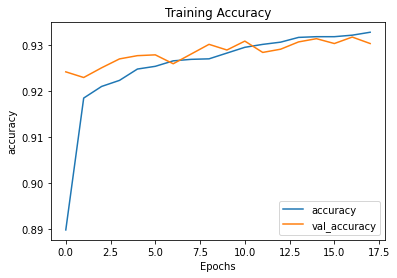

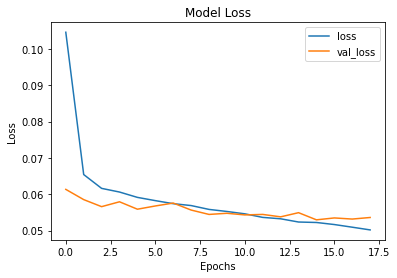

In [102]:
evaluate_obj = EvaluateModel()

evaluate_obj.Plot_History(history)

In [103]:
evaluate_obj.evaluate_model(model, X_test, y_test)

Accuracy   =   0.9329924175630401 

Sensitvity =   0.90997142828608 

Precision  =   0.9405065028710047 

F1 Score   =   0.9227495424436236 

Recall     =   0.90997142828608 

fpr        =   0.9815852682145717 

tpr        =   0.8383575883575883 

AUC        =   {0: 0.90997142828608, 1: 0.90997142828608} 



(0.9329924175630401,
 0.90997142828608,
 0.9405065028710047,
 0.9227495424436236,
 0.90997142828608,
 0.9815852682145717,
 0.8383575883575883,
 {0: 0.90997142828608, 1: 0.90997142828608})

In [104]:
evaluate_obj.Classification_Report(model, X_test, y_test)

'              precision    recall  f1-score   support\n\n           0       0.96      0.84      0.89      1924\n           1       0.92      0.98      0.95      3747\n\n    accuracy                           0.93      5671\n   macro avg       0.94      0.91      0.92      5671\nweighted avg       0.93      0.93      0.93      5671\n'

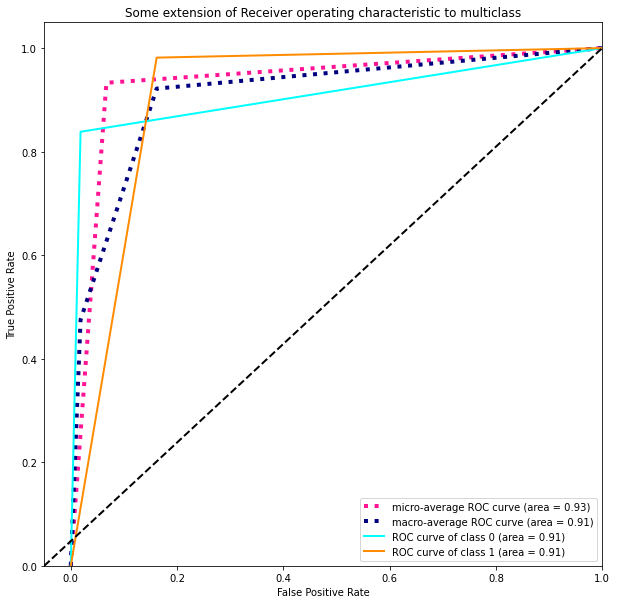

In [105]:
evaluate_obj.plot_roc_curve(model, X_test, y_test)

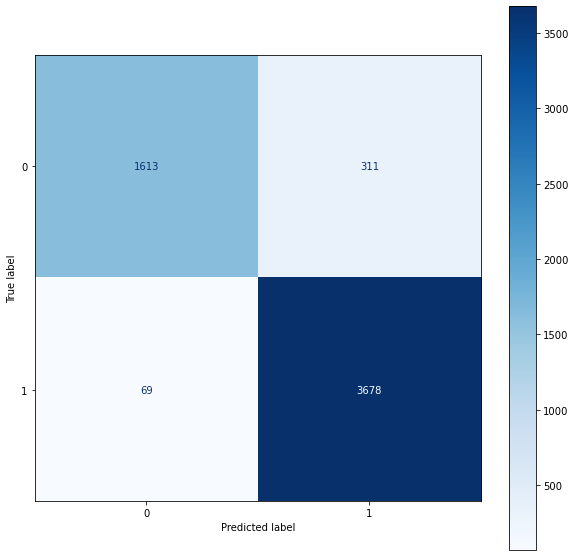

In [106]:
evaluate_obj.Confusion_Matrix(model, X_test, y_test)